# Fine-tune Multi-Genre Natural Language Inference on Amazon Shopping Query Dataset

## Check out GPU Type

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 27 04:40:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Check out RAM Size

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [3]:
! pip install -q datasets transformers

     |████████████████████████████████| 325 kB 14.1 MB/s 
     |████████████████████████████████| 4.0 MB 86.0 MB/s 
     |████████████████████████████████| 212 kB 94.4 MB/s 
     |████████████████████████████████| 136 kB 101.3 MB/s 
     |████████████████████████████████| 1.1 MB 67.7 MB/s 
     |████████████████████████████████| 77 kB 7.3 MB/s 
     |████████████████████████████████| 127 kB 99.5 MB/s 
     |████████████████████████████████| 895 kB 69.3 MB/s 
     |████████████████████████████████| 596 kB 81.8 MB/s 
     |████████████████████████████████| 6.6 MB 72.3 MB/s 
     |████████████████████████████████| 144 kB 99.9 MB/s 
     |████████████████████████████████| 271 kB 94.0 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [4]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Then you need to install Git-LFS. Uncomment the following instructions:

In [5]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [6]:
import transformers

print(transformers.__version__)

4.18.0


# Fine-tuning a model on a text classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a text classification task of the [Amazon Shopping Query Dataset](https://www.aicrowd.com/challenges/esci-challenge-for-improving-product-search).

![Widget inference on a text classification task](https://github.com/huggingface/notebooks/blob/main/examples/images/text_classification.png?raw=1)


- [MNLI](https://arxiv.org/abs/1704.05426) (Multi-Genre Natural Language Inference) Determine if a sentence entails, contradicts or is unrelated to a given hypothesis. (This dataset has two versions, one with the validation and test set coming from the same distribution, another called mismatched where the validation and test use out-of-domain data.)

We will see how to easily load the dataset for Query-Product Ranking tasks and use the `Trainer` API to fine-tune a model on it.

This notebook is built to run on MNLI task, with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a classification head. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [7]:
task = "mnli"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to load the data from the disc and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [8]:
from datasets import load_dataset, load_metric, list_metrics
list_metrics()

['accuracy',
 'bertscore',
 'bleu',
 'bleurt',
 'cer',
 'chrf',
 'code_eval',
 'comet',
 'competition_math',
 'coval',
 'cuad',
 'exact_match',
 'f1',
 'frugalscore',
 'glue',
 'google_bleu',
 'indic_glue',
 'mae',
 'mahalanobis',
 'matthews_correlation',
 'mauve',
 'mean_iou',
 'meteor',
 'mse',
 'pearsonr',
 'perplexity',
 'precision',
 'recall',
 'rouge',
 'sacrebleu',
 'sari',
 'seqeval',
 'spearmanr',
 'squad',
 'squad_v2',
 'super_glue',
 'ter',
 'wer',
 'wiki_split',
 'xnli',
 'xtreme_s']

## We can directly pass our task name to those functions. `load_dataset` will cache the dataset to avoid downloading it again the next time you run this cell.

In [9]:
actual_task = "mnli"
metric = load_metric('glue', actual_task)

The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

## Mount the Google Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

% cd drive/MyDrive/sna/

Mounted at /content/drive
/content/drive/MyDrive/sna


## Read in Amazon Shopping Query dataset

In [11]:
import datasets
import random
import pandas as pd
import numpy as np

product = pd.read_csv('data/product_catalogue-v0.2.csv', dtype="string")
train = pd.read_csv("data/train-v0.2.csv", dtype="string")
test = pd.read_csv("data/test_public-v0.2.csv", dtype="string")

## Dataset Preprocessing: Merge, Concatenate, Rename, Select, Replace

In [12]:
alled = train.merge(product, on="product_id", how="inner", validate="many_to_many")
alled = alled.fillna("")

alled['pro_all'] = alled['product_title'] + ". " +alled['product_brand']+ ". " + alled['product_color_name'] + ". " + alled["product_bullet_point"] + ". " + alled['product_description'] + "."

alled = alled[['query', 'pro_all', 'esci_label']]
alled = alled.rename(columns={'query': 'premise', 'pro_all': 'hypothesis', 'esci_label': 'label'})
alled = alled.reset_index()
alled = alled[['premise', 'hypothesis', 'label', 'index']]
alled = alled.rename(columns={'index': 'idx'})

label2int = {"exact": 0, "substitute": 1, "complement": 2, "irrelevant": 3}
alled['label'] = alled['label'].apply(func=lambda x: label2int[x])

alled

,premise,hypothesis,label,idx
0,!awnmower tires without rims,American Lawn Mower Company 1204-14 14-Inch 4-...,3,0
1,landmowers,American Lawn Mower Company 1204-14 14-Inch 4-...,0,1
2,lawn mower without motor,American Lawn Mower Company 1204-14 14-Inch 4-...,0,2
3,reel mower with grass catcher,American Lawn Mower Company 1204-14 14-Inch 4-...,1,3
4,!awnmower tires without rims,Oregon 72-107 Universal Wheel 7X150 Diamond Pl...,0,4
...,...,...,...,...
793361,ﾒｽﾃｨﾝ,メスティン アルミ飯盒 固形燃料ストーブ ポットホルダー 風除板 9枚付き キャンプ用品 ア...,2,793361
793362,ﾒｽﾃｨﾝ,メスティン キャンプ用メスティン アルミ飯盒 ポータブル飯盒 ハンゴウ クッカー バーべキュ...,0,793362
793363,ﾒｽﾃｨﾝ,トランギア(trangia) メスティン(TR-210) [並行輸入品]. trangia(...,0,793363
793364,ﾒｽﾃｨﾝ,MiliCamp MR-250 メスティン4点セットキャンプ 飯ごう バリ取り済 アウトドア...,2,793364


## Split the data into training, validation, test and downsample it for training

In [13]:
from sklearn.model_selection import train_test_split

train_count = 571223
train_flag = True
dev_count = 20000
dev_flag = True
test_count = 79337
test_flag = True
frac_train = 0.9
frac_test = 0.8

train_all, test = train_test_split(alled, train_size=frac_train, shuffle=True)
train, dev = train_test_split(train_all, train_size=frac_test, shuffle=True)
print('Before training shape:',train.shape)
print('Before dev shape:',dev.shape)
print('Before test shape:',test.shape)

train = train.sample(n=train_count)
dev = dev.sample(n=dev_count)
test = test.sample(n=test_count)

print('After training shape:',train.shape)
print('After dev shape:',dev.shape)
print('After test shape:',test.shape)

train.reset_index(drop=True, inplace=True)
dev.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Save each data
train.to_csv("data/train.csv", index=False)
dev.to_csv("data/dev.csv", index=False)
test.to_csv("data/test.csv", index=False)

Before training shape: (571223, 4)
Before dev shape: (142806, 4)
Before test shape: (79337, 4)
After training shape: (571223, 4)
After dev shape: (20000, 4)
After test shape: (79337, 4)


## load_dataset the train, validation, test from the disc

In [14]:
dataset = load_dataset("csv", data_files={'train': 'data/train.csv', 'validation': 'data/dev.csv', 'test': 'data/test.csv'})

Using custom data configuration default-2ab2c83f03cc5ace


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-2ab2c83f03cc5ace/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## To access an actual element, you need to select a split first, then give an index:

In [15]:
dataset["train"][20]

{'hypothesis': "THE PILL That Never Sleeps, Fast Acting Male Amplifier for Strength, Performance, Energy, and Endurance, 10 Capsules. THE PILL. Clear. The package weight of the product is 2.4 ounces\nDuring the summer months products may arrive warm but Amazon stores and ships products in accordance with manufacturers' recommendations, when provided.. .",
 'idx': 221189,
 'label': 1,
 'premise': 'viagra pills for men for sex long lasting'}

## To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [16]:
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(dataset["train"])

## The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [ ]:
metric

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [19]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

You can directly call this tokenizer on one sentence or a pair of sentences:

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

To preprocess our dataset, we will thus need the names of the columns containing the sentence(s). The following dictionary keeps track of the correspondence task to column names:

In [20]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

We can double check it does work on our current dataset:

In [21]:
sentence1_key, sentence2_key = task_to_keys[task]
if sentence2_key is None:
    print(f"Sentence: {dataset['train'][0][sentence1_key]}")
else:
    print(f"Sentence 1: {dataset['train'][0][sentence1_key]}")
    print(f"Sentence 2: {dataset['train'][0][sentence2_key]}")

Sentence 1: maid headwear
Sentence 2: Jaciya 18 Pack Bride Crystal Rhinestone Starfish Hair Pin Hair Jewelry Hair Accessories Women Headwear Headdress for Beach Themed Wedding,Party, hair clips for women. Jaciya. 18 Pcs Starfish. Hairpins consist of alloy, crystal rhinestone. Hair pin size: 3'' x 1''. Color: Silver.
Package included: 18pcs starfish hair pins with blue jewelry bag. Easy to handle and good for hairstyle diy.
Decorated with pearl and crystal, stylish design; Charming and graceful look. Good gift for mothers.
Good for wedding wearing, proms, party and other special occasions.
Good assistant for your make up and easy to DIY your own hairstyle. Hairpins decorated with pearls make you beautiful and charming.. Jaciya 18 Pack Bride Crystal Rhinestone Starfish Hair Pin Hair Jewelry Hair Accessories Women Headwear Headdress for Beach Themed Wedding,Party, Hair clips for women.


### We can them write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model.

In [22]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True, padding=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True, padding=True)

### To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [23]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/572 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/80 [00:00<?, ?ba/s]

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since all our tasks are about sentence classification, we use the `AutoModelForSequenceClassification` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us. The only thing we have to specify is the number of labels for our problem (which is always 2, except for STS-B which is a regression problem and MNLI where we have 3 labels):

In [24]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define two more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. **It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:**

In [25]:
metric_name = "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
print(metric_name)
model_name = model_checkpoint.split("/")[-1]
print(model_name)

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
)

accuracy
distilbert-base-uncased


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/bert-finetuned-mrpc"` or `"huggingface/bert-finetuned-mrpc"`).

## Define our `Trainer`
The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits (our just squeeze the last axis in the case of STS-B):

In [26]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

## Then we just need to pass all of this along with our datasets to the `Trainer`:

In [27]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/content/drive/MyDrive/sna/distilbert-base-uncased-finetuned-mnli is already a clone of https://huggingface.co/LiYuan/distilbert-base-uncased-finetuned-mnli. Make sure you pull the latest changes with `repo.git_pull()`.


You might wonder why we pass along the `tokenizer` when we already preprocessed our data. This is because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it. You can customize this part by defining and passing your own `data_collator` which will receive the samples like the dictionaries seen above and will need to return a dictionary of tensors.

# We can now finetune our model by just calling the `train` method:

In [28]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 571223
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 71404


Epoch,Training Loss,Validation Loss,Accuracy
1,0.898100,0.866245,0.637050


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-mnli/checkpoint-35702
Configuration saved in distilbert-base-uncased-finetuned-mnli/checkpoint-35702/config.json
Model weights saved in distilbert-base-uncased-finetuned-mnli/checkpoint-35702/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/checkpoint-35702/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-mnli/checkpoint-35702/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/tokenizer_config.json
Special tokens file saved in distilb

Epoch,Training Loss,Validation Loss,Accuracy
1,0.898100,0.866245,0.637050
2,0.783700,0.824447,0.661700


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased-finetuned-mnli/checkpoint-71404
Configuration saved in distilbert-base-uncased-finetuned-mnli/checkpoint-71404/config.json
Model weights saved in distilbert-base-uncased-finetuned-mnli/checkpoint-71404/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-mnli/checkpoint-71404/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-mnli/checkpoint-71404/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-un

TrainOutput(global_step=71404, training_loss=0.8870834159113821, metrics={'train_runtime': 18454.6151, 'train_samples_per_second': 61.906, 'train_steps_per_second': 3.869, 'total_flos': 1.5134224748069683e+17, 'train_loss': 0.8870834159113821, 'epoch': 2.0})

## We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [29]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20000
  Batch size = 16


{'epoch': 2.0,
 'eval_accuracy': 0.6617,
 'eval_loss': 0.8244466781616211,
 'eval_runtime': 111.9382,
 'eval_samples_per_second': 178.67,
 'eval_steps_per_second': 11.167}

## Evaluate our best trained model on held-out test set

In [35]:
predictions = trainer.predict(encoded_dataset["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

preds = np.argmax(predictions.predictions, axis=-1)
metric.compute(predictions=preds, references=predictions.label_ids)

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx. If premise, hypothesis, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 79337
  Batch size = 16


(79337, 4) (79337,)


{'accuracy': 0.6571334938301171}

## Plot a confusion matrix on the held-out test set

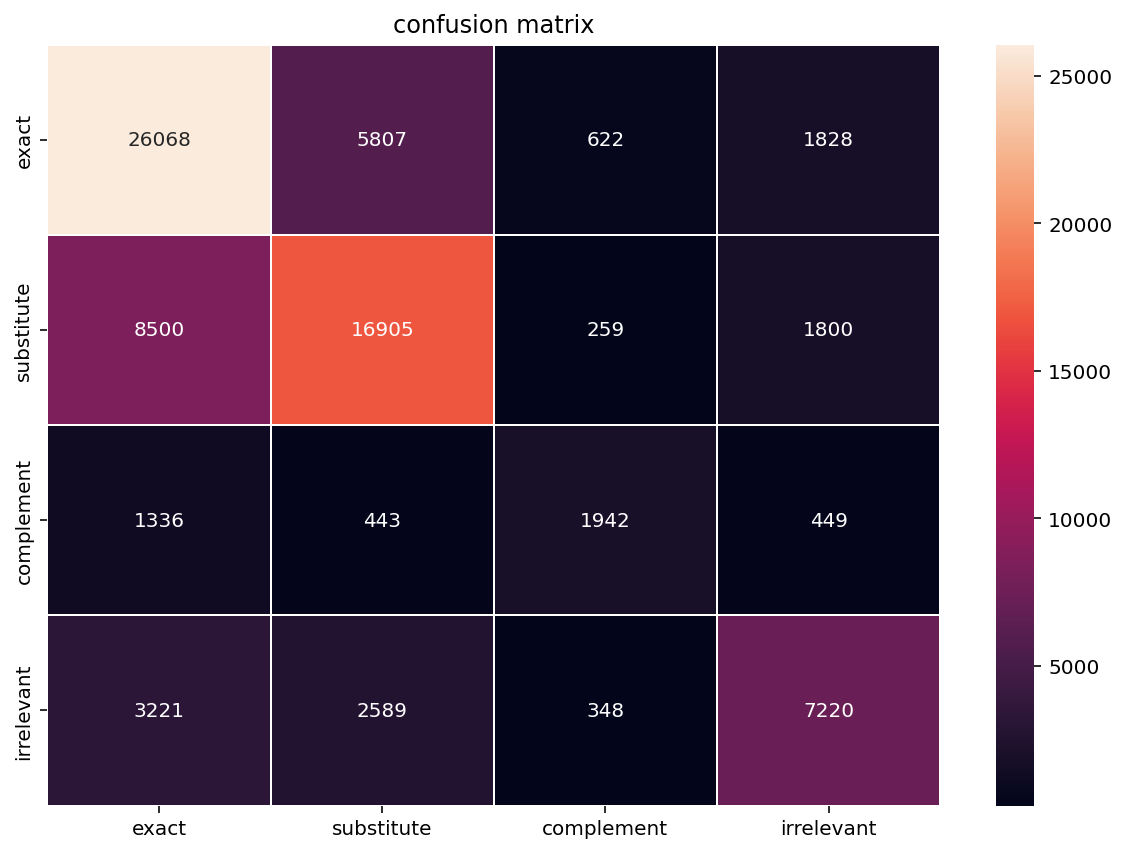

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

array = confusion_matrix(y_true=predictions.label_ids, y_pred=preds)

df_cm = pd.DataFrame(array, index = [i for i in list(label2int.keys())],
                  columns = [i for i in list(label2int.keys())])

plt.figure(figsize = (10,7))
ax = plt.axes()
sn.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax);
ax.set_title(f'confusion matrix')
plt.show()

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub()

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

## Reload our best model from the disc and test it

In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

path = "/content/drive/MyDrive/sna/distilbert-base-uncased-finetuned-mnli"

model = AutoModelForSequenceClassification.from_pretrained(path)
tokenizer = AutoTokenizer.from_pretrained(path)

features = tokenizer([dataset["test"][0]['premise'], dataset["test"][1]['premise']], [dataset["test"][0]['hypothesis'], dataset["test"][1]['hypothesis']],  padding=True, truncation=True, return_tensors="pt")

model.eval()
with torch.no_grad():
    scores = model(**features).logits
    print(scores)

loading configuration file /content/drive/MyDrive/sna/distilbert-base-uncased-finetuned-mnli/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/sna/distilbert-base-uncased-finetuned-mnli",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading weights

tensor([[ 2.4494, -0.0620, -2.0296, -1.4261],
        [ 2.9035,  0.4867, -3.1780, -1.1103]])


## Hyperparameter search

The `Trainer` supports hyperparameter search using [optuna](https://optuna.org/) or [Ray Tune](https://docs.ray.io/en/latest/tune/). For this last section you will need either of those libraries installed, just uncomment the line you want on the next cell and run it.

In [ ]:
! pip install -q optuna
! pip install -q ray[tune]

During hyperparameter search, the `Trainer` will run several trainings, so it needs to have the model defined via a function (so it can be reinitialized at each new run) instead of just having it passed. We jsut use the same function as before:

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

And we can instantiate our `Trainer` like before:

In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"].shard(index=1, num_shards=10000),
    eval_dataset=encoded_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

The method we call this time is `hyperparameter_search`. Note that it can take a long time to run on the full dataset for some of the tasks. You can try to find some good hyperparameter on a portion of the training dataset by replacing the `train_dataset` line above by:
```python
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 
```
for 1/10th of the dataset. Then you can run a full training on the best hyperparameters picked by the search.

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

The `hyperparameter_search` method returns a `BestRun` objects, which contains the value of the objective maximized (by default the sum of all metrics) and the hyperparameters it used for that run.

In [194]:
best_run

NameError: ignored

You can customize the objective to maximize by passing along a `compute_objective` function to the `hyperparameter_search` method, and you can customize the search space by passing a `hp_space` argument to `hyperparameter_search`. See this [forum post](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10) for some examples.

To reproduce the best training, just set the hyperparameters in your `TrainingArgument` before creating a `Trainer`:

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Matthews Correlation
1,No log,0.467531,0.446775
2,0.428433,0.476509,0.521516


TrainOutput(global_step=536, training_loss=0.4191349371155696)